In [8]:
import pyDR # this notebook worked well with git commit: 15b82d57ec10193603d9486500925ff5249747f0
from pyDR.Selection import select_tools as selt

import emcee
from scipy import optimize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import MDAnalysis as mda
import sys, os

import pickle

import copy, glob

In [2]:
import pyfftw

print (f'{pyfftw.__version__=}') # for me installing like this worked: conda install pyfftw=0.13.0=py39h51d1ae8_0

pyfftw.__version__='0.13.0'


In [3]:
mda.__version__

'2.0.0'

In [4]:
def save_pickle(out_path, data):
    with open(out_path, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pickle(pickle_path):
    with open(pickle_path, 'rb') as handle:
        return pickle.load(handle)

In [5]:
root_dir = '/cluster/work/igc/mlehner/nmr_project/1ubq/'

top_path = root_dir + '/ubq_desolv.gro'

trajs = [root_dir + '/test_001/run_001/traj_4us_PBC_fit.xtc', 
         root_dir + '/test_002/run_001/traj_4us_PBC_fit.xtc', 
         root_dir + '/test_015/run_001/traj_4us_PBC_fit.xtc', 
         root_dir + '/test_003/run_001/traj_4us_PBC_fit.xtc', 
         root_dir + '/test_010/run_001/traj_4us_PBC_fit.xtc',
         root_dir + '/test_014/run_001/traj_4us_PBC_fit.xtc',
         root_dir + '/test_011/run_001/traj_4us_PBC_fit.xtc',
         root_dir + '/charmm36/production/ubq_prod_4us_PBC_fit.xtc', 
        ]

dict_id = ['test_001', 'test_002',
           'test_015', 'test_003', 
           'test_010', 'test_014', 
           'test_011', 'charmm']

amber = 'ff99SB-nmr1-ildn'

labels = [f'{amber} / TIP3P', f'{amber}  (refit methyl) / TIP3P', 
          f'{amber} / TIP4P', f'{amber}  (refit methyl) / TIP4P',
          f'{amber} / TIP5P', f'{amber}  (refit methyl) / TIP5P',
          'ff99SB-ILDN / TIP3P', 'charmm36m / TIP3P',
          ]

labels = [f'amber / TIP3P', f'amber (refit methyl) / TIP3P', 
          f'amber / TIP4P', f'amber (refit methyl) / TIP4P',
          f'amber / TIP5P', f'amber (refit methyl) / TIP5P',
          'ff99SB / TIP3P', 'charmm36m / TIP3P',
          ]

labels = [f'Anmr-stn-3P', f'Anmr-met-3P', 
          f'Anmr-stn-4P', f'Anmr-met-4P',
          f'Anmr-stn-5P', f'Anmr-met-5P',
          'Adef-stn-3P', f'C36m-stn-3P',
          ]



colors = ['#05668D', '#26bcf7', 
          '#6A4E24', '#D4B483', 
          'firebrick', '#B46A6B', 
          '#022B3B', '#60046E',
         ]


def get_color(label):
    for l, c in zip(labels, colors):
        if l == label:
            return c
        
        
def get_dictID(label):
    for l, id in zip(labels, dict_id):
        if l == label:
            return id

## Load the data that was fit previously

In [6]:
# path_data = sorted(glob.glob('/cluster/home/cchampion/work/NMR/ubiquitin/data_iles/*.pkl'))

def extract_sublist(all_pickles, match_text):
    return [p for p in all_pickles if match_text in p]

def extract_order_params_all_methyls(path_pickles, labels):
    
    all_pickles = glob.glob(f'{path_pickles}/*.pkl')
    bond_labels = load_pickle(all_pickles[0]).keys()
    
    results = {}
    
    for l in labels:
        ff_id = get_dictID(l)
        chunked_data = [load_pickle(data) for data in extract_sublist(all_pickles, ff_id)]
        
        sub_results = {}
        
        for b in bond_labels:
            s2 = []
            for d in chunked_data:
                tmp = (d[b]['mcmc']['mean']['Ss2']) * (d[b]['mcmc']['mean']['Sf2'])
                #tmp = (d[b]['mcmc']['mean']['tau_s'])
                #print (tmp)
                s2.append(tmp)
            
            sub_results[b] = np.round(np.mean(s2), 2)
            
        results[ff_id] = sub_results
        
    return results


def extract_order_params_isoleucines(path_pickles, labels):
    
    all_pickles = glob.glob(f'{path_pickles}/*.pkl')
    bond_labels = load_pickle(all_pickles[0]).keys()
    
    results = {}
    
    for l in labels:
        ff_id = get_dictID(l)
        chunked_data = [load_pickle(data) for data in extract_sublist(all_pickles, ff_id)]
        
        sub_results = {}
        
        for b in bond_labels:
            if 'CG1_CD' not in b:
                continue
            s2 = []
            for d in chunked_data:
                tmp = (d[b]['mcmc']['mean']['Ss2']) * (d[b]['mcmc']['mean']['Sf2'])
                #tmp = (d[b]['mcmc']['mean']['tau_s'])
                #print (tmp)
                s2.append(tmp)
            
            sub_results[b] = np.round(np.mean(s2), 2)
            sub_results[f'{b}_err'] = np.round(np.std(s2), 2)
        results[ff_id] = sub_results
        
    return results

# Load the data based on the previous functions

In [9]:
path_pickles = os.getcwd()+'/data/'

md_s2_data = extract_order_params_all_methyls(path_pickles, labels)

/tmp/ipykernel_3634322/2995609492.py:7: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  return pickle.load(handle)
/tmp/ipykernel_3634322/2995609492.py:7: DeprecationWarning: Please use `LbfgsInvHessProduct` from the `scipy.optimize` namespace, the `scipy.optimize.lbfgsb` namespace is deprecated.
  return pickle.load(handle)


In [10]:
md_iles_s2_data = extract_order_params_isoleucines(path_pickles, labels)

/tmp/ipykernel_3634322/2995609492.py:7: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  return pickle.load(handle)
/tmp/ipykernel_3634322/2995609492.py:7: DeprecationWarning: Please use `LbfgsInvHessProduct` from the `scipy.optimize` namespace, the `scipy.optimize.lbfgsb` namespace is deprecated.
  return pickle.load(handle)


In [35]:
# Find the mapping of labels between my data and Rafael Bruschweiler's data

In [11]:
path_exp = '/fileserver/pine/pine2/cchampion/NMR/ubiquitin/exp_data'

exper_rb = pd.read_csv(f'{path_exp}/Ubq_methyl_S2_NASR_fig3b.txt', sep='\t')

map_rb2md = {}

# Isolecine

for i in [3, 13, 23, 30, 36, 44, 61]:
    map_rb2md[f'I{i}CD1'] = f'{i}_CG1_CD'
    map_rb2md[f'I{i}CG2'] = f'{i}_CG2_CB'
    
# Leucine's I will average them out later maybe

for i in [8, 15, 43, 50, 56, 67, 69, 71, 73]:
    map_rb2md[f'L{i}CD1'] = f'{i}_CD1_CG'
    map_rb2md[f'L{i}CD2'] = f'{i}_CD2_CG'

# Valine's I will average them out later maybe

for i in [5, 17, 26, 70]:
    map_rb2md[f'V{i}CG1'] = f'{i}_CG1_CB'
    map_rb2md[f'V{i}CG2'] = f'{i}_CG2_CB'

# Threonine 

for i in [7, 9, 12, 14, 22, 55]:
    map_rb2md[f'T{i}CG2'] = f'{i}_CG2_CB'

# And the Alanines  

for i in [28, 46]:
    map_rb2md[f'A{i}CB'] = f'{i}_CB_CA'

    
def re_order_md_data(md_data, rb_data, use_only=None):
    """
    This function will reorder a list of md_data to ensure 
    the data is indexed just like R.B. data. 
    
    Give as input MD data for a single FF
    
    use only can be used to filter out specific residues only 
    
    
    """
    reordered_s2 = []
    
    for rb_label in rb_data['Residue']:
        if rb_label not in map_rb2md.keys():
            print ('skipping: ' + rb_label)
            reordered_s2.append(np.nan)
        else:
            
            if use_only is not None and use_only not in rb_label:
                reordered_s2.append(np.nan)
                continue
            
            #print (rb_label)
            reordered_s2.append(md_data[map_rb2md[rb_label]])
    
    return reordered_s2 

# Fabien's data:

In [12]:
exp_data = pd.read_csv(f'{path_exp}/experimental_ls_fits.csv')
exp_data.columns = exp_data.columns.str.replace(" ", "")

exp_s2    = np.array(exp_data['exp_ss2'] * exp_data['exp_sf2'])
exp_s2err = np.sqrt([exp_data['exp_ss2_err_minus'] **2 + exp_data['exp_sf2_err_minus'] **2, 
                 exp_data['exp_ss2_err_plus'] **2 + exp_data['exp_sf2_err_plus'] **2]).T


"""
exp_s2    = np.array(exp_data['exp_sf2'])
exp_s2err = np.array([exp_data['exp_sf2_err_minus'], exp_data['exp_sf2_err_plus']]).T
"""

#
# Notes: Fabien suggested to compare the data to simple MF for residues 3, 23, 30 and 61  
#

# ile 3 
exp_s2[0] = 0.69
exp_s2err[0][0] = 0.01 
exp_s2err[0][1] = 0.01 

# ile23
exp_s2[2] = 0.49
exp_s2err[2][0] = exp_s2err[2][1] = 0.01

# ile30
exp_s2[3] = 0.75
exp_s2err[3][0] = exp_s2err[3][1] = 0.01

# ile 61 
exp_s2[6] = 0.54
exp_s2err[6][0] = exp_s2err[6][1] = 0.01

In [13]:
def average_out_md_data(rb_data, md_data):
    """
    Here we average the data for symmetric side chains (i.e. Valines, Leucines)
    
    We set the 
    
    """
    
    averaged_rb_data = copy.deepcopy(rb_data)
    averaged_md_data =  copy.deepcopy(md_data)
    
    delete_indices = []
    
    # 1: Average the Leucines:
    for i in [8, 15, 43, 50, 56, 67, 69, 71, 73]:
        # Here we will replace the Value of CD1 and delete the CD2 
        index = averaged_rb_data.index[averaged_rb_data['Residue'] == f'L{i}CD1']
        if len(index) == 0:
            index = averaged_rb_data.index[averaged_rb_data['Residue'] == f'L{i}CD2']
                                    
        avg_s2 = np.average(filter_rb_data(rb_data, use_only=str(i))['S2_NASR'])
        avg_err = np.average(filter_rb_data(rb_data, use_only=str(i))['S2_NASR_err'])
        
        averaged_rb_data.at[index[0],'S2_NASR'] = avg_s2
        averaged_rb_data.at[index[0],'S2_NASR_err'] = avg_err
        
        index2 = averaged_rb_data.index[averaged_rb_data['Residue'] == f'L{i}CD2']
        
        if len(index2) == 1:
            delete_indices.append(index2[0])
        
        # Now do the averaging for the MD data:
        
        averaged_md_data[f'{i}_CD1_CG'] = (averaged_md_data[f'{i}_CD1_CG'] + averaged_md_data[f'{i}_CD2_CG']) / 2
        del averaged_md_data[f'{i}_CD2_CG']
        
    # 2 Average out the Valines:
    for i in [5, 17, 26, 70]:
        # Here we will replace the Value of CD1 and delete the CD2 
        index = averaged_rb_data.index[averaged_rb_data['Residue'] == f'V{i}CG1']
        if len(index) == 0:
            index = averaged_rb_data.index[averaged_rb_data['Residue'] == f'V{i}CG2']
                                    
        avg_s2 = np.average(filter_rb_data(rb_data, use_only=str(i))['S2_NASR'])
        avg_err = np.average(filter_rb_data(rb_data, use_only=str(i))['S2_NASR_err'])
        
        averaged_rb_data.at[index[0],'S2_NASR'] = avg_s2
        averaged_rb_data.at[index[0],'S2_NASR_err'] = avg_err

        index2 = averaged_rb_data.index[averaged_rb_data['Residue'] == f'V{i}CG2']

        if len(index2) == 1:
            delete_indices.append(index2[0])
        
        # 
        averaged_md_data[f'{i}_CG1_CB'] = (averaged_md_data[f'{i}_CG1_CB'] + averaged_md_data[f'{i}_CG2_CB']) / 2
        del averaged_md_data[f'{i}_CG2_CB']
        
        
    averaged_rb_data = averaged_rb_data.drop(delete_indices)
    
    return averaged_rb_data, averaged_md_data
    
    

# Get the error for all isoleucine types for all FFs

In [14]:
def filter_nan(l1, l2):
    
    new_l1 = []
    new_l2 = []
    
    for item1, item2 in zip(l1, l2):
        if not np.isnan(item1):
            new_l1.append(item1)
            new_l2.append(item2) 
    return np.array(new_l1), np.array(new_l2)

def average_error_by_residue(full_md_data, exper_data):
    
    average_errors = {}
    average_errors['labels'] = ['All', 'I', 'L', 'V', 'T', 'A']
    
    for ff in full_md_data.keys():
        
        ff_data = []
    
        for resname in average_errors['labels']:
            
            if resname == 'All': resname = None
            
            sub_md = re_order_md_data(full_md_data[ff], exper_data, use_only = resname)                        
            tmp1, tmp2 = filter_nan(sub_md, exper_data['S2_NASR'])
            
            # print (f'{len(tmp1)}  for {resname}')
            
            ff_data.append(np.mean(np.abs(tmp1 - tmp2)))
            
        average_errors[ff] = np.round(ff_data, 3)
    return average_errors
    
avg_errors = average_error_by_residue(md_s2_data, exper_rb)

# Make the plot

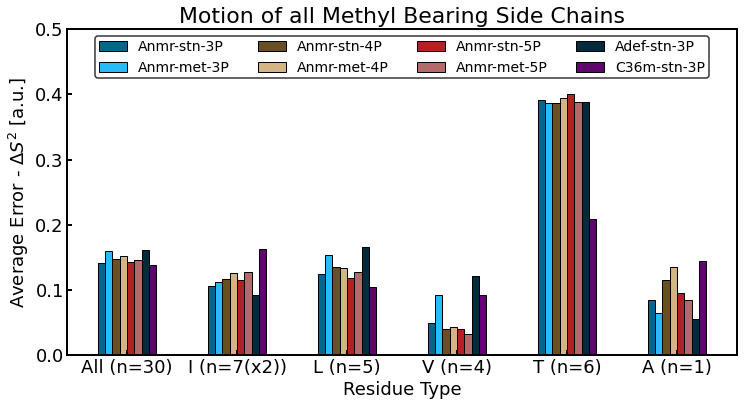

In [15]:
fig, ax = plt.subplots(1, figsize=(12, 6))

ntypes = 6# len(avg_errors['labels'])

width = 1 / (ntypes * 1.25)
x = 2*np.arange(ntypes) + 0.5*ntypes*width # the label locations

num = 7 

# finding proper offsets

if num%2==0:offsets = np.arange(-num/2, num/2+0.001, step =1)
else:offsets = np.arange(-num/2, num/2+0.001)

    
for i, (label, ffid) in enumerate(zip(labels, dict_id)):    
    if ffid not in avg_errors.keys():
        continue
    
    color = get_color(label)
    
    #if 'ff99SB' in label:
    #    color = 'darkgrey'
    
    ax.bar(x+ offsets[i]*width, avg_errors[ffid], width = width, color = color, 
           linewidth = 1, edgecolor = 'black', label = label)
    

fontsize = 18

fuller_labels = [f'{a} (n={b})' for a, b in zip(avg_errors['labels'], [30, '7(x2)', 5, 4, 6, 1])]

ax.set_xticks(x)
ax.set_xticklabels(fuller_labels, fontsize = fontsize)

ax.set_xlabel('Residue Type', fontsize = fontsize)
ax.set_ylabel('Average Error - $\Delta{}S^2$ [a.u.]', fontsize = fontsize)

ax.set_title('Motion of all Methyl Bearing Side Chains', fontsize = 22)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)


ax.tick_params(axis="both",direction="in", length = 5, width = 2, labelsize=18)
ax.tick_params(axis="both",direction="in", length = 5, width = 2, labelsize=18)



#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

#ax.legend(ncol=2, fontsize=18, loc = 'upper center', 
#          edgecolor = 'black', fancybox = True, bbox_to_anchor=(1.15, 0.5))  

ax.set_ylim([0, 0.5])

legend = ax.legend(ncol =4, fontsize=14, loc = 'upper center', 
          edgecolor = 'black', fancybox = True, borderpad = 0.25)  

frame = legend.get_frame()
frame.set_linewidth(1.5)


In [22]:
fig.savefig('/home/cchampion/tmp/mf_allresidues.pdf', dpi=300, facecolor='white')

# Plotting just the Isoleucine:

In [16]:
def plot_experimental(ax, exp_s2, exp_s2err, size = 40):
    """
    Helper function to plot the relaxometry data from Fabien
    
    """
    #colors = ['white', 'black', 'white', 'white', 'black', 'black', 'white']
    colors = ['black', 'black', 'black', 'black', 'black', 'black', 'black']
    #colors = ['purple', 'black', 'purple', 'purple', 'black', 'black', 'purple']
    
    
    for i in range(num_iles):
        asym_errors = [[x] for x in(exp_s2err[i])]
        if i == 0:
            ax.errorbar(x[i], exp_s2[i], yerr= asym_errors, ecolor = colors[i], c=colors[i], 
                        fmt ='s', capthick=2, capsize=4, label ='Relaxometry', mec = colors[i], 
                        linewidth = 2, zorder=9, alpha = 1, markersize = size)
        else:
            ax.errorbar(x[i], exp_s2[i], yerr= asym_errors, ecolor = colors[i], 
                        c=colors[i], fmt ='s', capthick=2, capsize=4, 
                        mec = colors[i], linewidth = 2, zorder=9, alpha = 1, markersize = size)

            
def get_ile_cdelta(rb_data):
    """
        Extracts just the Isoleucines C_delta values from R.B. 
    """
    s2s_rb = []
    s2s_err = []
    
    for i, r in exper_rb.iterrows():
        if 'I' in r['Residue'] and 'CD' in r['Residue']:
            s2s_rb.append(r['S2_NASR'])
            s2s_err.append(r['S2_NASR_err'])
    
    return s2s_rb #, # s2s_err

def filter_rb_data(rb_data, use_only = 'I'):
    return rb_data.loc[rb_data['Residue'].str.contains(use_only)]
            
def convert2list(data):
    """
    Converts the data for the Isoleucines for the plotting
    (from a dict to a nicer list)
    """
    vals = []
    errs = []
    for k, v in data.items():
        if 'err' in k:
            errs.append(v)
        else:
            vals.append(v)
    
    return vals, errs

[  4.  39.  74. 109. 144. 179. 214.]
1.1428571428571428
test_001
Anmr-stn-3P
test_002
Anmr-met-3P
test_015
Anmr-stn-4P
test_003
Anmr-met-4P
test_010
Anmr-stn-5P
test_014
Anmr-met-5P
test_011
Adef-stn-3P
charmm
C36m-stn-3P


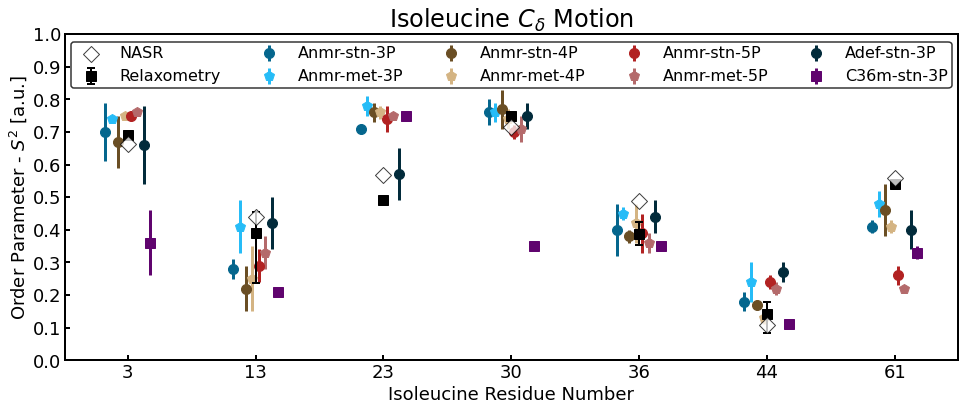

In [17]:
fig, ax = plt.subplots(1, figsize=(16, 6))
from matplotlib.cm import get_cmap

# Count number of isoleucines:
num_iles = 7 

width = 10 / (num_iles * 1.25)
x = 35*np.arange(num_iles) + 0.5*num_iles*width # the label locations

print (x)
print (width)

num = len(dict_id) # number of FFs
if num%2==0:offsets = np.arange(-num_iles/2, num_iles/2+0.001, step =1)
else:offsets = np.arange(-num_iles/2, num_iles/2+0.001)

offsets *= 1.75
    
plot_experimental(ax, exp_s2, exp_s2err, size = 10)

ax.scatter(x, get_ile_cdelta(exper_rb), color = 'white', edgecolor = 'black',  
           marker ='D', label = 'NASR', zorder = 10, s = 128, alpha = 0.75)
    
for i, (label, ffid) in enumerate(zip(labels, dict_id)):    
    # continue
    vals, errs = convert2list(md_iles_s2_data[ffid])
    color = get_color(label)
    print (ffid)
    print (label)
    
    marker = 'o'
    alpha = 1 # 0.5
    markersize = 10
    
    
    if 'met' in label:
        marker = 'p'
        markersize /= 1 #1.15
    elif 'C36' in label:
        marker = 's'
        alpha  = 1
        
    #if 'ff99SB' in label:
    #    color = 'darkgrey'
    
    
    # Plot Force Field data all at once: 
    ax.errorbar(x+ offsets[i],
                vals, errs, 
                color = color,
                label = label, 
                ls = '', 
                marker = marker, 
                alpha = alpha, 
                markersize = markersize,
                linewidth = 3,
                zorder = 1
               )

ax.set_xticks(x)
ax.set_xticklabels([3, 13, 23, 30, 36, 44, 61], fontsize = 18)
ax.set_xlabel('Isoleucine Residue Number', fontsize = 18)

ax.set_ylim([0, 1])
ax.set_yticks(np.arange(0, 1.001, 0.1))
ax.set_yticklabels(np.round(np.arange(0, 1.001, 0.1), 1), fontsize = 18)

ax.set_ylabel('Order Parameter - $S^{2}$ [a.u.]', fontsize = 18)

ax.set_title('Isoleucine $C_\delta$ Motion', fontsize = 24)

# to re-order the legend

#handles, labels = ax.get_legend_handles_labels()
#idx_exp = labels.index('Relaxometry')
#neworder = np.append(idx_exp, np.delete(np.arange(0, len(labels)), idx_exp)) 

#ax.legend([handles[idx] for idx in neworder],[labels[idx] for idx in neworder], 
#           ncol =5, fontsize=7, loc = 'upper center', edgecolor = 'black', fancybox = True)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)


ax.tick_params(axis="both",direction="in", length = 5, width = 2, labelsize=18)
ax.tick_params(axis="both",direction="in", length = 5, width = 2, labelsize=18)



#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

#ax.legend(ncol=2, fontsize=18, loc = 'upper center', 
#          edgecolor = 'black', fancybox = True, bbox_to_anchor=(1.15, 0.5))  

legend = ax.legend(ncol =5, fontsize=16, loc = 'upper center', 
          edgecolor = 'black', fancybox = True, borderpad = 0.25)  

frame = legend.get_frame()
frame.set_linewidth(1.5)
# borderpad

In [18]:
# fig.savefig('/home/cchampion/tmp/mf_isoleucines.pdf', dpi=300, facecolor='white')